<h1><center>STAT-542 HW9</center></h1>
Sharvi Tomar (stomar2)

## About HW9

In this HW, we use two examples to demonstrate how the RKHS and Representer Theorem are used in practice. In both questions, we will use the radial basis kernel, defined as 

$$K(\mathbf{x}, \mathbf{z}) = e^{- \frac{\lVert \mathbf{x} - \mathbf{z}\rVert^2}{2\sigma^2}}.$$

You are not required to tune the parameter $\sigma$. The information will be given. 

## Question 1 [45 Points] Kernel Ridge Regression 

Let's first generate a set of data using the following code (or some similar code in Python):

In [285]:
import random
import math 
import numpy as np
import pandas as pd
from numpy.linalg import inv, norm

random.seed(1)

n = 500
p = 2

X = np.random.normal(0, 1, size=(n, p))
y = 2*np.array(list(map(math.sin, X[:,0] * 2))) + 2*np.array(list(map(math.atan, X[:,1]*4)))+ np.random.normal(0, 0.5, n)

df = pd.DataFrame({'x1':X[:,0],'x2': X[:,1], 'y':y})
train = df.iloc[0:200, ]
test = df.iloc[200:, ]
test = test.reset_index(drop=True)

[5 Points] As a comparison, we can first fit a ridge regression to this data. Use the `train` part to fit a ridge regression using the `glmnet()` package with 10-fold cross-validation. Use `lambda.min` as your tuning parameter to predict the testing data. What is the prediction error? 

In [286]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import RidgeCV

model = RidgeCV(alphas=[0.11, 0.022, 0.0033,  0.00033,  0.000033, 1e-4, 1e-5,1e-3, 1e-10,1e-9,5], cv=10)
model.fit(train.iloc[:,0:2], train["y"])
predictions = model.predict(test.iloc[:,0:2])
pred_error = mean_squared_error(predictions, test["y"])

print("The prediction error on the testing data is", pred_error)

The prediction error on the testing data is 2.9579669756792772


To fit a kernel ridge regression, we use the following formulation:

$$\underset{\boldsymbol \alpha}{\text{minimize}} \quad \frac{1}{n} \big\lVert \mathbf{y} -\mathbf{K} \boldsymbol \alpha \big\rVert^2 + \lambda \boldsymbol \alpha^\text{T}  \mathbf{K} \alpha$$

It should be noted that you could add an $\alpha_0$ term to this regression to rigorously add the intercept term. However, the theoretical mean of $Y$ is zero. Hence, it is not a crucial issue, and not required here. Following our derivation in the class, perform the following to complete this kernel ridge regression:


  * [10 Points] Compute the 200 $\times$ 200 kernel matrix $\mathbf{K}$. Use a Gaussian kernel and $\sigma = 1$. 
  * [10 Points] Based on the kernel ridge regression derivation, get the solution $\boldsymbol \alpha$. Use $\lambda = 0.01$
  * [10 Points] The prediction of kernel ridge regression involves computing the kernel between a testing data and all the training data. To be specific, if we have a new testing data $z$, then the prediction $\widehat{f}(z)$ is 
  $$\widehat{f}(z) = \sum_{i = 1}^n \alpha_i K(z, x_i)$$
  Since we have 300 testing data, this involves calculating a 300 $\times$ 200 testing data kernel matrix, denoted as $K_\text{test}$, and the vector of prediction is $K_\text{test} \boldsymbol \alpha$. 
  * [10 Points] Predict the testing data using the kernel and $\widehat{\boldsymbol \alpha}$. What is the prediction error? Is it better than the ridge regression?

In [287]:
def radial_basis_kernel(x, z, sigma):
    return math.exp(-(x-z)**2/(2* sigma**2))

def kernel_matrix(x, z, sigma):
    ret = np.zeros([len(x),len(z)])
    for i in range(len(x)):
        for j in range(len(z)):
            ret[i][j] = radial_basis_kernel(x["x1"][i], z["x1"][j], sigma) * radial_basis_kernel(x["x2"][i], z["x2"][j], sigma)
        
    return ret

In [288]:
# Computing 200  ×  200 kernel matrix  𝐊 
K_train = kernel_matrix(train, train , 1)
K_train.shape

(200, 200)

In [289]:
# Getting alpha
alpha = np.dot(inv(200*0.01*np.identity(200) + K_train) , train["y"])
alpha.shape

(200,)

In [290]:
# Computing K_test
K_test = kernel_matrix(test, train , 1)
K_test.shape

(300, 200)

In [291]:
# Computing prediction on test data using K_test and alpha
predictions_using_kernel = np.dot(K_test, alpha)
pred_kernel_error = mean_squared_error(predictions_using_kernel, test["y"])

print("The prediction error on the testing data is", pred_kernel_error)

The prediction error on the testing data is 0.572317378339438


The prediction error for the kernel regression is better than the ridge as we get a prediction error which one-fourth of the prediction error obtained using ridge regression. Hence, kernel regression is better than the ridge regression.

## Question 2 [55 Points] Non-linear SVM as Penalized Version

Recall that in HW8, we solved SVM using a penalized loss framework, with the logistic loss function:
$$L(y, f(x)) = \log(1 + e^{- y f(x)}).$$


Again, we can specify the form of $f(\cdot)$ as in a RKHS. And the penalized objective function becomes  

$$\frac{1}{n} \sum_{i=1}^n L(y_i, K_i^\text{T} \boldsymbol \alpha) + \lambda \alpha^\text{T} \mathbf{K} \alpha$$

where $\mathbf{K}$ is the same $n \times n$ kernel matrix as before and $K_i$ is the $i$th column of $\mathbf{K}$. The data are generated by the following code. 

In [320]:
import matplotlib.pyplot as plt
random.seed(1)

n = 500
p = 2

X = np.random.uniform(-2, 2, size=(n, p))
#y = np.array(list(map(np.sign, X[:,1]))) - np.array(list(map(math.sin, math.pi*X[:, 0])))
y = np.array(list(map(np.sign, X[:,1] - np.array(list(map(math.sin, math.pi*X[:, 0]))))))

df = pd.DataFrame({'x1':X[:,0],'x2': X[:,1], 'y':y})
train = df.iloc[0:200, ]
test = df.iloc[200:, ]
test = test.reset_index(drop=True)

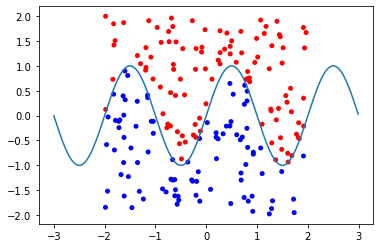

In [321]:
import matplotlib.pyplot as plt

col = np.where(train["y"]>0,'r','b')

plt.scatter(train["x1"], train["x2"], c=col, s=25, linewidth=0)
plt.plot(np.arange(-3, 3, 0.01), np.array(list(map(math.sin, math.pi*np.arange(-3, 3, 0.01)))))

plt.show()

Similar to the HW8 linear SVM penalized version, we perform the following steps to complete this model fitting:

  * [15 Points] Write a penalized loss objective function `SVMfn(b, K, y, lambda)` corresponding to the form we specified. Make sure to use the $1/n$ scale in the loss function part. 
  * [20 Points] Drive the gradient of the loss function, typeset with LaTex. Then write a gradient function `SVMgr(b, K, y, lambda)` to implement it. 
  * [20 Points] Use the `optim()` function to solve this optimization problem by supplying the objective function and gradient function. Use $\sigma = 0.2$ and $\lambda = 0.01$. Initialize your coefficients as zeros. Report the following:
    + The optimal loss function 
    + A confusion table of the training data
    + Mis-classification rate on training data.
  * It could be difficult to obtain the decision line itself. However, its relatively easy to obtain the fitted label for the testing data. Hence, calculate the fitted label of the testing data and report the classification error. Plot the testing data using the fitted labels as colors. You should also add the true decision line (since you already know the true data generator). This would allow you to visualize (approximately) the decision line. You do not need to plot the original labels. 

Note: 1) In a real problem, you can perform cross-validation to find the best tuning parameters. 2) You may also add a constant term $\alpha_0$ to the problem to take care of intercept. These two are not required for the HW. 

In [322]:
def loss_func(alpha, K, y, lambda_val):
    n = K.shape[0]
    return sum(np.log(1 + np.exp(- np.dot(K, alpha) * y)))/n + lambda_val * np.dot(alpha.T, np.dot(K, alpha))

$L(y,f(x))=log(1+e^{-yf(x)})$ and $f(x)=K\alpha$

The gradient of $L(\alpha)$ is
$\frac{\partial L}{\partial \alpha}= \frac{\partial L}{\partial f}\frac{\partial f}{\partial\alpha}$ =$−y\frac{e^{−yf(x)}}{1+e^{−yf(x)}}K$

where
$\frac{\partial L}{\partial f}=−y\frac{e^{−yf(x)}}{1+e^{−yf(x)}}$ and $\frac{\partial f}{\partial \alpha}=K$


Penalization component derivative wrt $\alpha$ is equal to $2\lambda$$\alpha K$

Therefore, the gradient of the loss function with scaling is 

$$\frac{\partial L}{\partial f}\frac{\partial f}{\partial\alpha} =\frac{−y}{n}\frac{e^{−yf(x)}}{1+e^{−yf(x)}}K + 2\lambda K\alpha $$

In [323]:
def gradient_func(alpha, K, y, lambda_val):
    n = K.shape[0]
    e1 = np.exp(-y * np.dot(K, alpha))/(1 +  np.exp(-y * np.dot(K, alpha)))
    e2 = 2*lambda_val * np.dot(K, alpha)
    return - y*np.dot(e1,K)/n + e2

In [324]:
from scipy.optimize import minimize

x0 = np.zeros(200)
K = kernel_matrix(train, train , 0.02)

res = minimize(loss_func, x0, args=(K, train["y"], 0.01), method='BFGS', jac=gradient_func, options={'disp': True})
#res = minimize(loss_func, x0, args=(K, train["y"], 0.01), method='BFGS', options={'disp': True})

Optimization terminated successfully.
         Current function value: 0.663036
         Iterations: 23
         Function evaluations: 26
         Gradient evaluations: 26


In [325]:
print("The optimal loss function:", res.fun)

The optimal loss function: 0.6630358086079179


In [326]:
train_predictions = np.dot(K, res.x)

In [327]:
train_actual = np.where(train["y"] > 0, 1, -1)
train_pred = np.where(train_predictions > 0, 1, -1)

In [328]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_actual, train_pred)

print("Confusion table of the training data:") 
cm

Confusion table of the training data:


array([[ 92,   0],
       [  0, 108]])

In [329]:
# Mis-classification rate on training data
print("Mis-classification rate on training data is:",(cm[0,1]+cm[1,0])/sum(sum(cm)))

Mis-classification rate on training data is: 0.0


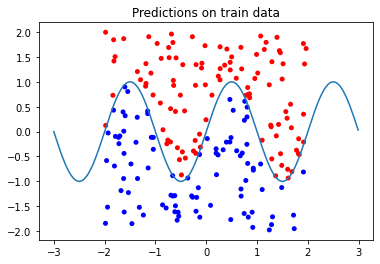

In [330]:
train_predictions = np.dot(K, res.x)

col = np.where(train_predictions>0,'r','b')

plt.scatter(train["x1"], train["x2"], c=col, s=25, linewidth=0)
plt.plot(np.arange(-3, 3, 0.01), np.array(list(map(math.sin, math.pi*np.arange(-3, 3, 0.01)))))
plt.title("Predictions on train data")
plt.show()

In [331]:
# calculate the fitted label of the testing data 
K_test2 = kernel_matrix(test, train , 0.02)
test_prediction2 = np.dot(K_test2, res.x)


In [332]:
# report the classification error
test_actual = np.where(test["y"] > 0, 1, -1)
test_pred2 = np.where(test_prediction2 > 0, 1, -1)
cm2 = confusion_matrix(test_actual, test_pred2)
# Mis-classification rate on training data
print("Mis-classification rate on test data is:",(cm2[0,1]+cm2[1,0])/sum(sum(cm2)))

Mis-classification rate on test data is: 0.03666666666666667


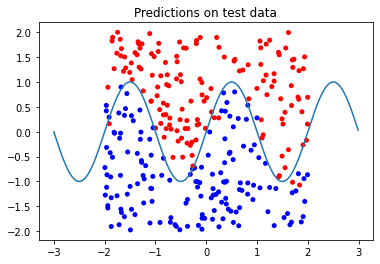

In [333]:
# Plot the testing data using the fitted labels as colors. 

col2 = np.where(test_prediction2>0,'r','b')

plt.scatter(test["x1"], test["x2"], c=col2, s=25, linewidth=0)
plt.plot(np.arange(-3, 3, 0.01), np.array(list(map(math.sin, math.pi*np.arange(-3, 3, 0.01)))))
plt.title("Predictions on test data")
plt.show()